In [65]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

The distance from $L_2$ to the baricenter of sistem is given by the positive solution of the following equation:
$$\gamma - (1 - \mu)/(\gamma + \mu)^2 - \mu/(\gamma - 1 + \mu)^2,$$

$$\mu = \frac{M_s}{M_p + M_s},$$
where $M_p$ and $M_s$ denote the masses of the primary and the secondary (smaller of the two primaries) body, respectively.

The equations of motion in the barycentric reference frame (nondimentionlized):
\begin{align}
\ddot{x} - 2\dot{y} - x &= - \frac{(1-\mu)(x+\mu)}{r_p^3} - \frac{\mu(x-(1-\mu))}{r_s^3}, \\
\ddot{y} + 2\dot{x} - y &= - \frac{(1-\mu)y}{r_p^3} - \frac{\mu y}{r_s^3}, \\
\ddot{z} &= - \frac{(1-\mu)z}{r_p^3} - \frac{\mu z}{r_s^3},
\end{align}
where
$$r_p = \sqrt{(x+\mu)^2 + y^2 + z^2}, \quad r_s = \sqrt{(x-(1-\mu))^2 + y^2 + z^2}$$, according to [1]

Distance between two primaries is equal to 1, center of coordinate axes is based in baricenter of sistema.
The conversion from units of distance, velocity, and time in the unprimed, normalized system to the primed, dimensionalized system is:
\begin{align}
d' &= L\cdot d, \\
s' &= V\cdot s, \\
t' &= \frac{T}{2\pi}t,
\end{align}
where where $L$ is the distance between the centers of $M_P$ and $M_S$, $V$ is the orbital velocity of $M_S$, $T$ is the orbital period of $M_P$ and $M_S$.

In further code we used following constants:
    $$\mu = 1.215\cdot10^{-2},  [1]$$
    $$L_2 = 1.556825,  [2]$$


In the last frame we check the behaviour of energy relative mistake: as you can see, computing deffects are negligible. 

[1] Dynamical Systems, the Three-Body Problem and Space Mission Design, http://www.cds.caltech.edu/~marsden/volume/missiondesign/KoLoMaRo_DMissionBk.pdf

[2] Libration point orbits and manifolds: design and station-keeping, 
http://www.mathnet.ru/links/d214da1304703fe544f855e9ed635481/ipmp1942.pdf


In [66]:
class Characteristics(object):
    pass

param = Characteristics()
param.mu = 1.215*1e-2

time = Characteristics()
time.begin = 0
time.end = 20
time.dt = 0.05

In [72]:
#L2 coordinate is computed
def get_L2_quintic(mu):
    def quintic_L2(x):
        return x - (1 - param.mu)/(x + param.mu)**2 - param.mu/(x - 1 + param.mu)**2
        
    root = fsolve(quintic_L2, 1 + mu, xtol=1e-10)
    return root[0] 

get_L2_quintic(param.mu) + param.mu

1.1678299130947354

In [68]:
def ode(t, r, param):
    x = r[0]
    y = r[1]
    z = r[2]
    v_x = r[3]
    v_y = r[4]
    v_z = r[5]
    
    r10 = [x + param.mu, y, z]
    r20 = [x + param.mu - 1, y, z]
    r1 = np.linalg.norm(r10)
    r2 = np.linalg.norm(r20)
    
    dxdt = np.zeros(6)
    dxdt[:3] = [v_x, v_y, v_z]
    dxdt[3] = 2 * v_y + x - (1 - param.mu)*(x + param.mu)/(r1**3) - param.mu*(x - 1 + param.mu)/(r2**3)
    dxdt[4] = -2 * v_x + y - (1 - param.mu)*y/(r1**3) - param.mu*y/(r2**3)
    dxdt[5] = -(1 - param.mu)*z/(r1**3) - param.mu*z/(r2**3)
    return dxdt
    
rP_0 = [get_L2_quintic(param.mu), 0, 0]
vP_0 = [0, 0, 0]
r_0 = rP_0 + vP_0

t_sol = np.arange(time.begin, time.end, time.dt)

solution = sci.solve_ivp(lambda t, r: ode(t, r, param), (time.begin, time.end), r_0, t_eval = t_sol, atol = 1e-10, rtol = 1e-10)

r_sol = solution.y.T

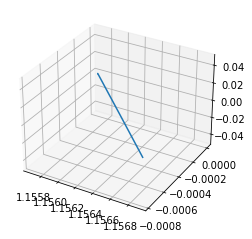

In [69]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot(r_sol[:, 0], r_sol[:, 1], r_sol[:, 2], label='parametric curve')
#plt.ticklabel_format(useOffset = False)

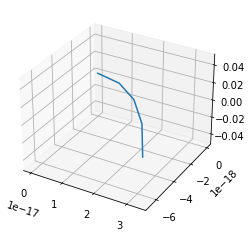

In [70]:
#Acceleration

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection = '3d')
ax2.plot(r_sol[:5, 3], r_sol[:5, 4], r_sol[:5, 5], label='parametric curve')
plt.ticklabel_format(useOffset = False)

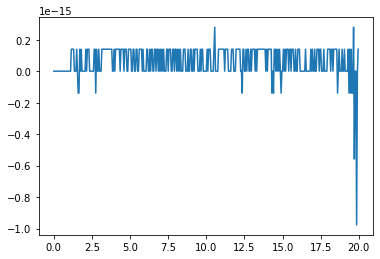

In [71]:
#GRAPHIC OF SYSTHEM`S ENERGY

U = np.zeros(np.size(t_sol))
Relative = np.zeros(np.size(t_sol))

for i in range(np.size(t_sol)):
    x = r_sol[i][0]
    y = r_sol[i][1]
    z = r_sol[i][2]
    v_x = r_sol[i][3]
    v_y = r_sol[i][4]
    v_z = r_sol[i][5]
    r10 = [x + param.mu, y, z]
    r20 = [x + param.mu - 1, y, z]
    r1 = np.linalg.norm(r10)
    r2 = np.linalg.norm(r20)
    U[i] = -0.5*((1 - param.mu)*(r1**2) + param.mu*(r2**2)) - (1 - param.mu)/r1 - param.mu/r2
    C = -(v_x**2 + v_y**2 + v_z**2) - 2*U[i]
    if i == 0:
        C_0 = C
    Relative[i] = (C-C_0)/C_0
    
    
plt.plot(t_sol, Relative)
plt.ticklabel_format(useOffset = False)

In [1]:
21000/384400

0.05463059313215401

In [20]:
9999.75/384400

0.02601391779396462